In [1]:
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import pickle
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet 
import statsmodels.tsa.stattools as ts
 
from helper import clean_data
from helper import vix_prime_combine
from helper import dftest
from helper import split_data

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
vix_close , prime, weekly_vix, monthly_vix = clean_data()

## Checks from class notebooks (timeseries_autocorrelation)

In [3]:
len(weekly_vix.index.unique())

1516

In [4]:
weekly_vix.index.max() - weekly_vix.index.min()

Timedelta('10605 days 00:00:00')

In [5]:
res = []
for i in range(1,100):
    res.append(weekly_vix.vix_close.autocorr(lag=i))

In [6]:
for i in range(360,370):
    print(i, weekly_vix.vix_close.autocorr(lag=i))

360 -0.10631333975074628
361 -0.10537657192508124
362 -0.1047285227203106
363 -0.10234715218964859
364 -0.09882673404518973
365 -0.09666553367753829
366 -0.09422826533172199
367 -0.08915533741426662
368 -0.08173508141821138
369 -0.07603158397100884


In [7]:
np_res = np.array(res)

In [8]:
np_res.argmin()

98

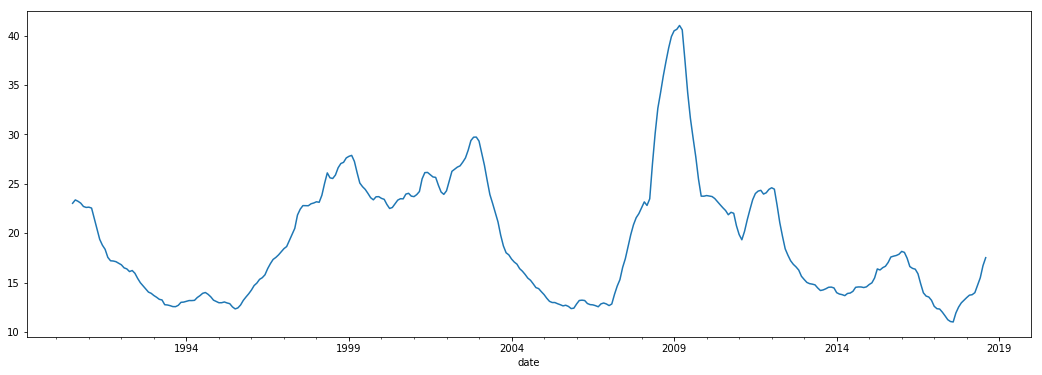

In [9]:
monthly_vix.vix_close.rolling(window=12,center=True).mean().plot(figsize=(18,6))

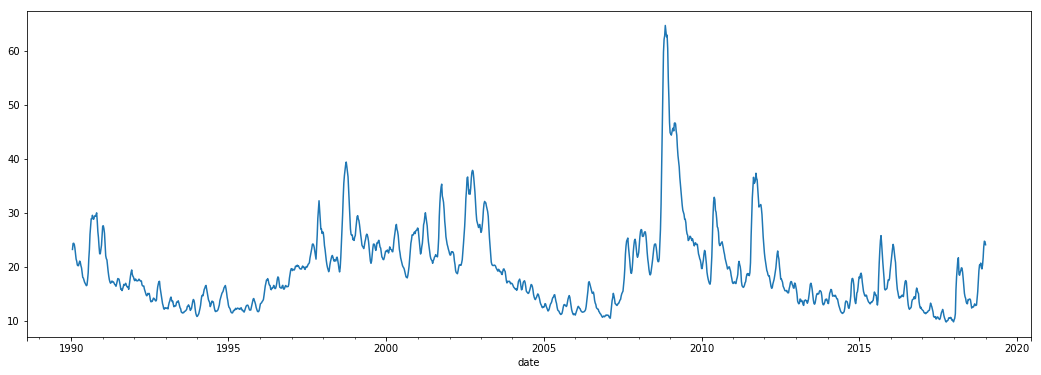

In [10]:
weekly_vix.vix_close.rolling(window=5, center=True).mean().plot(figsize=(18,6));

In [11]:
pct_series = weekly_vix.vix_close.diff()/weekly_vix.vix_close

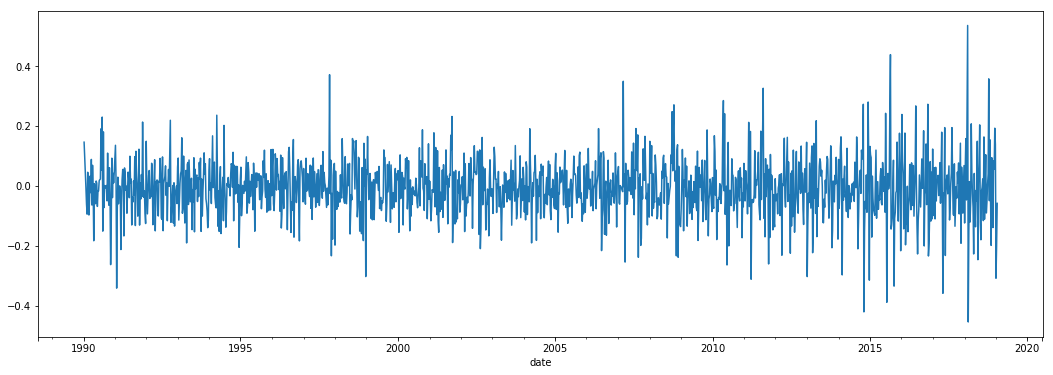

In [12]:
pct_series.plot(figsize=(18,6))

In [13]:
weekly_vix.vix_close.autocorr(lag=52*12)

0.1962742188417796

In [14]:
print(weekly_vix.vix_close.std())
print(weekly_vix.vix_close.diff().std()) ## this may be best.
print(weekly_vix.vix_close.diff().diff().std())

7.694458772199208
2.2072060984407402
3.162295968102394


## Data Distribution

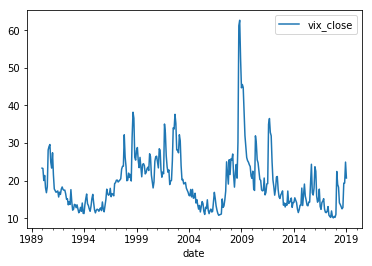

In [15]:
monthly_vix.plot() ## do I need to worry about the financial meltdown? Probably.

In [16]:
monthly_vix.columns

Index(['vix_close'], dtype='object')

In [17]:
annual_vix = vix_close.resample('A').mean()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


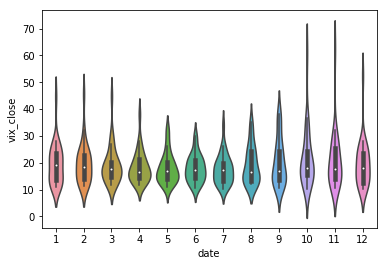

In [19]:
sns.violinplot(x=monthly_vix.index.month,y=monthly_vix.vix_close)

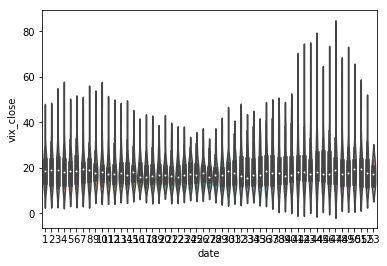

In [20]:
sns.violinplot(x=weekly_vix.index.week,y=weekly_vix.vix_close) ## volitility spikes in fall and winter

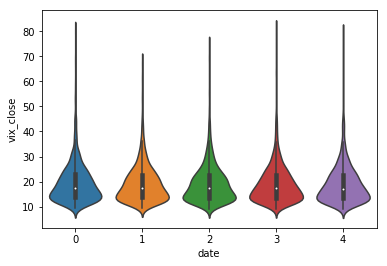

In [21]:
sns.violinplot(x=vix_close.index.dayofweek,y=vix_close.vix_close) #Monday - Friday doesn't matter.

## tests from class

In [22]:
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()


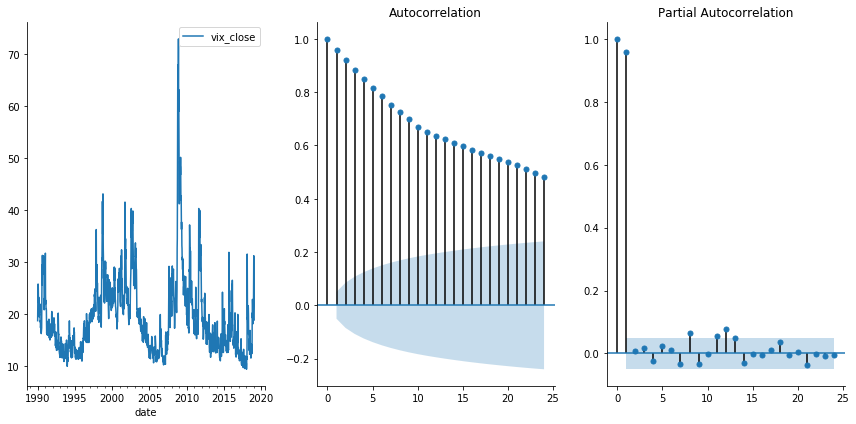

In [23]:
plots(weekly_vix, lags=24);


In [24]:
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly_vix.vix_close, order=(1,1,0), seasonal_order=(0,1,0,12), trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          vix_close   No. Observations:                  349
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1022.475
Date:                            Tue, 22 Jan 2019   AIC                           2050.949
Time:                                    13:01:57   BIC                           2062.401
Sample:                                01-31-1990   HQIC                          2055.514
                                     - 01-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0113      0.278      0.041      0.967      -0.534       0.557
ar.L1          0.1081      0.048      2.266      0.023       0.015       0.202
sigma2        25.7451      1.092     23.584      0.000      23.606      27.885
===================================================================================
Ljung-Box (Q):                      185.52   Jarque-Bera (JB):              1275.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

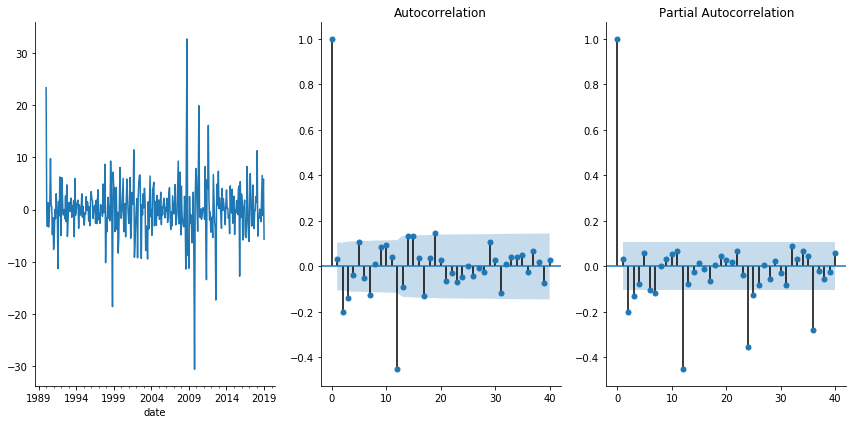

In [25]:
plots(sar.resid, lags=40);

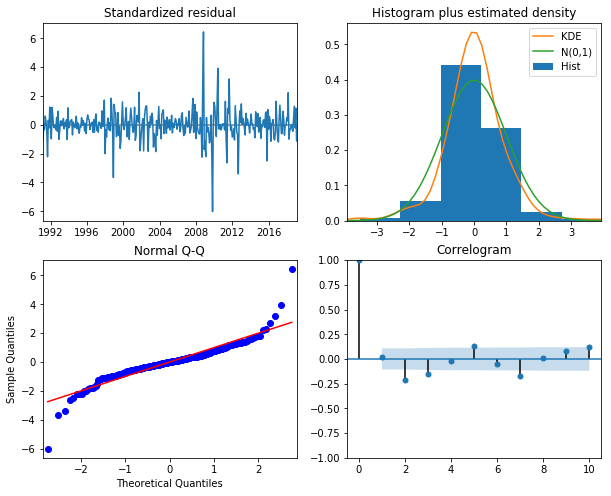

In [26]:
sar.plot_diagnostics(figsize=(10, 8));

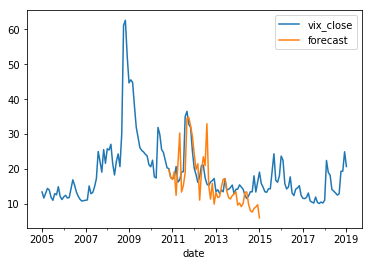

In [27]:
monthly_vix['forecast'] = sar.predict(start = 250, end= 300, dynamic=30)  
monthly_vix[180:][['vix_close', 'forecast']].plot();

## Try data as % change

In [28]:
# Let's try in percent change
vix_df = vix_close.vix_close.diff()/vix_close.vix_close

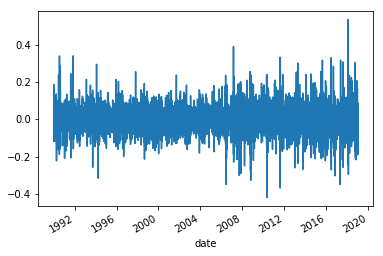

In [29]:
vix_df.plot()

In [30]:
monthly_vix.head()

,vix_close,forecast
date,,
1990-01-31,23.347273,NaN
1990-02-28,23.262632,NaN
1990-03-31,20.062273,NaN
1990-04-30,21.403500,NaN
1990-05-31,18.097727,NaN
